# Demonstration of Robust Workflow

This notebook demonstrates the use of the RobustWorkflow class from the quends package. This workflow allows a user to process DataStreams that are not stationary if they choose to do so by setting the flag `operate_safe = False`. With this flag set to False, if a DataStream is not stationary, the code will return the mean based on the last 33% of the data, with an uncertainty of 100%. The dictionary of results that is returned also contains metadata to indicate if the DataStream was processed normally, or if there were exceptions (such as non-stationarity), and how those were mitigated.

Note that this workflow currently defaults to heuristic methods for determining stationarity and start of statistical steady state (SSS). These methods mainly look at the behavior of the rolling-window-averaged mean of the signal. These methods are therefore not guaranteeing SSS in the true sense of the definition as they only look at the 0th moment of the statistics. However, the methods work quite well for short and super noisy signals.



## Import Required Libraries and Helper Functions

In [1]:
# Import required libraries
import numpy as np
import quends as qnds
import pprint
import matplotlib.pyplot as plt
import pandas as pd

# Custom class to specify formatting of floats (and tuples of floats) in pprint 
# and limit the number of significant digits in results dictionaries printed to screen
class FloatFormatter(pprint.PrettyPrinter):
    def _format(self, object, stream, indent, allowance, context, level):
        if isinstance(object, tuple):
            stream.write('(')
            for i, item in enumerate(object):
                if isinstance(item, float):
                    stream.write(format(item, '.4g'))
                else:
                    super()._format(item, stream, indent, allowance, context, level)
                if i < len(object) - 1:
                    stream.write(', ')
            stream.write(')')
        elif isinstance(object, float):
            stream.write(format(object, '.4g'))
        else:
            super()._format(object, stream, indent, allowance, context, level)

# use as 'formatter.pprint(object)'
formatter = FloatFormatter(indent=0)


## Demonstration on a variety of signals
For these demonstrations, we set the verbosity to 2 so you can see plots of intermediate steps.

### Synthetic data: linear transient to a plateau with some noise

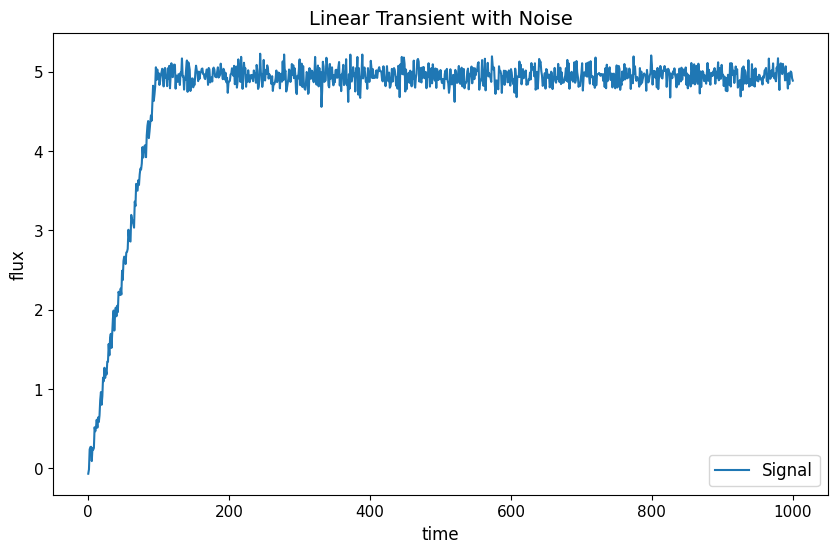

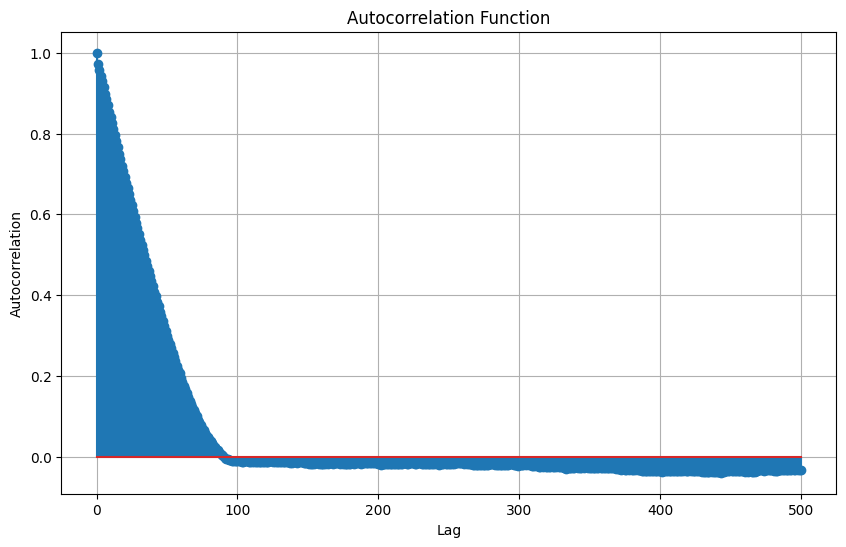

stats decorrelation length 72 gives smoothing window of 288 points.


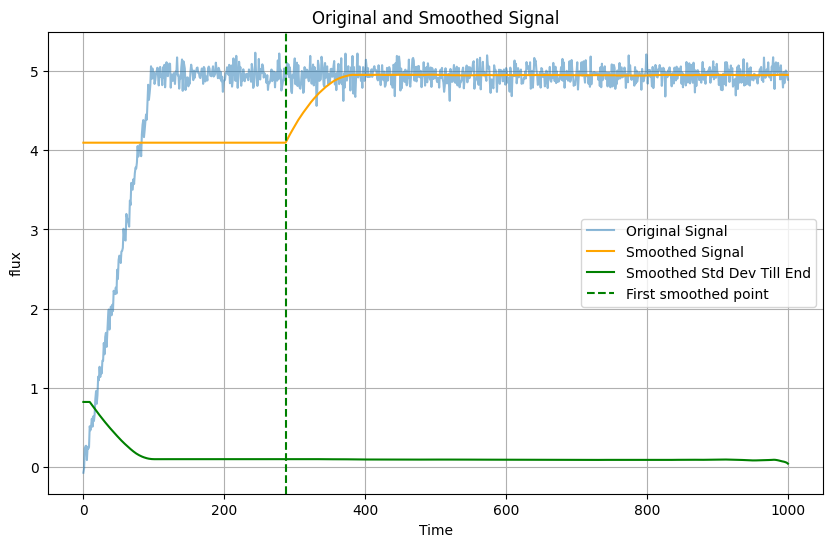

Getting start of SSS based on smoothed signal:
Index where criterion is met: 333
Rolling window: 288
time where criterion is met: 333.0
time at start of SSS (adjusted for rolling window): 102.0


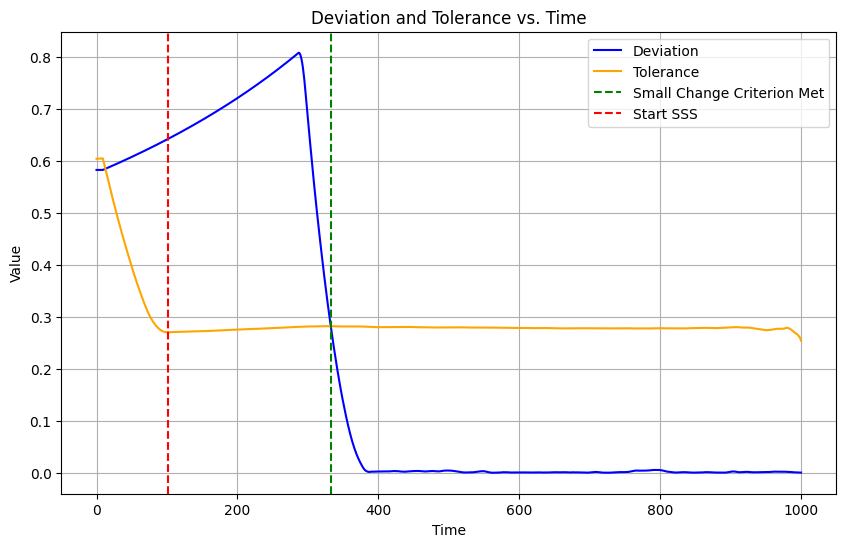

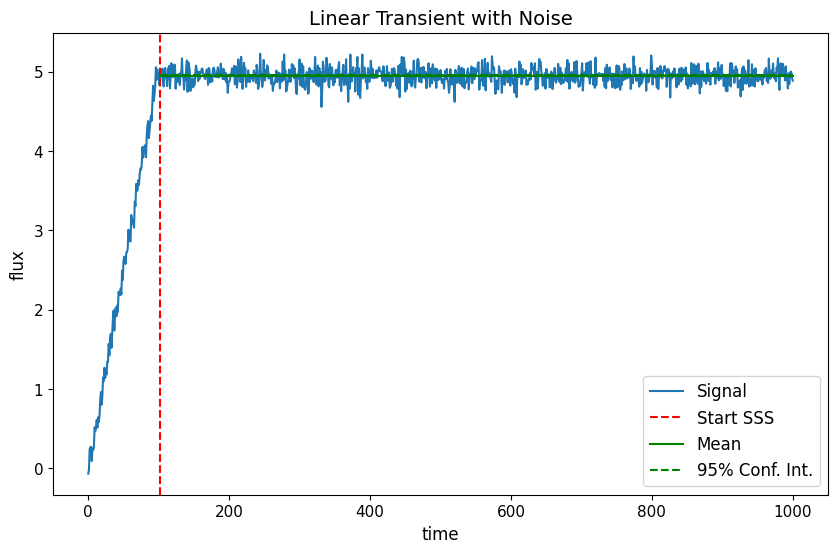

In [3]:
# Create time trace with linear transient up to flat signal with noise

# set up arrays for time and signal
arr_time = np.linspace(start=0,stop=1000,num=1001)
arr_signal = np.zeros_like(arr_time)

n_pts = arr_signal.shape[0]

for i_arr in range(100):
    arr_signal[i_arr] = 0.05*arr_time[i_arr]
for i_arr in range(100,n_pts):
    arr_signal[i_arr] = arr_signal[99]

# add some noise
arr_signal += np.random.normal(loc=0.0, scale=0.1, size=arr_signal.shape)

my_label = "Linear Transient with Noise"
# build data_stream
df_flat = pd.DataFrame({"time":arr_time,"flux":arr_signal})

ds_flat = qnds.DataStream(df_flat)

# Set up the workflow with high verbosity to see intermediate steps
my_wrkflw = qnds.RobustWorkflow(operate_safe=False, verbosity=2)

col = "flux" # variable to look at
my_wrkflw.plot_signal_basic_stats(ds_flat,col,label=my_label)

# get statistics
my_stats = my_wrkflw.process_data_steam(ds_flat,col)

# Plot trace with mean and start of steady state
if not my_stats[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw.plot_signal_basic_stats(ds_flat,col,stats=my_stats,label=my_label)

Analysis:
- The first plot shows the raw signal before doing any processing. 
- The first step in the analysis is to compute the signal autocorrelation (2nd plot), which is used to define a decorrelation length. 
- This decorrelation length is used to define an averaging window (by default 4 x the decorrelation length), which is used to smoothen the signal.
- The third graph shows the orginal signal along with the smoothed signal, as well as the standard deviation of the original signal, computed at each point from the current point till the end of the signal.
- This information is used to determine statistical steady state (SSS) as the tail segment of the orginal signal for which any point of the smoothed signal does not deviate much from the mean of the smoothed segment. The threshold for deviation from the mean is a fraction of the mean of the smoothed signal, and this fraction depends on the std dev of the original signal. In other words, signals that are very noisy allow for larger deviations from the mean while being in SSS. As the points in the smoothed signal depend on all points in the averaging window, the actual start of SSS is set to be a fraction of the averaging window before the point where the SSS criterion is met, as shown in the 4th figure.
- By default, the start of SSS is set to 80% of the averaging window before the criterion is met. The last figure shows how this coincides well with the transition from linear slope to plateau in this synthetic examples. However, as many of the analysis parameters are set very heuristically, this is more due to serendipity than to design.

## Demonstration of batch processing on a set of files 

In [ ]:
# Specify the file paths, and include one file that is deliberately not stationary
data_paths = ["./cgyro/output_nu0_02.csv", "./cgyro/output_nu0_05.csv", "./testdata/non-stat.csv", "./cgyro/output_nu0_10.csv", "./cgyro/output_nu0_50.csv", "./cgyro/output_nu1_0.csv"]
# data_paths = ["./testdata/non-stat.csv"]

# Load one data file to see what variables they contain.
# Assume all files have the same variables in them
data_stream = qnds.from_csv(data_paths[0])
data_vars = data_stream.variables()
print("The data stream contains the following variables:")
for column, name in enumerate(data_vars):
    print(f"{column}: {name}")

col = data_vars[2] # work with first variable (stored after index and time)


## Process Files

In [ ]:
# Set up workflow object
my_wrkflw = qnds.RobustWorkflow(operate_safe=False, verbosity=0)

# Process files
for data_path in data_paths:
    # Load the data into a data_stream object
    data_stream = qnds.from_csv(data_path)

    # Get statistics
    my_stats = my_wrkflw.process_data_steam(data_stream,col)

    # Plot trace with mean and start of steady state
    if not my_stats[col]["metadata"]["mitigation"] == "Drop":
        my_wrkflw.plot_signal_basic_stats(data_stream,col,stats=my_stats,label=data_path)
    

### Demo a situation where the data is stationary but there is no statistical steady state found due to bad hyperparameters


In [ ]:
ds0 = qnds.from_csv(data_paths[0])

# Set up workflow object and use very badly chosen hyperparameters
my_wrkflw0 = qnds.RobustWorkflow(operate_safe=False, verbosity=2, max_lag_frac=0.05,decor_multiplier=1.0,std_dev_frac=0.001,fudge_fac=0.0)

# Get statistics
my_stats = my_wrkflw0.process_data_steam(ds0,col)

# Print results
print(f"Results for {data_paths[0]}:") 
formatter.pprint(my_stats)

# Plot trace with mean and start of steady state
if not my_stats[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw0.plot_signal_basic_stats(data_stream,col,my_stats,label=data_path)


### Test code on some truly custom data signals

In [ ]:
# Create time trace with linear transient and no noise
import pandas as pd

# set up arrays for time and signal
arr_time = np.linspace(start=0,stop=1000,num=1001)
arr_signal = np.zeros_like(arr_time)

n_pts = arr_signal.shape[0]

for i_arr in range(100):
    arr_signal[i_arr] = 0.05*arr_time[i_arr]
for i_arr in range(100,n_pts):
    arr_signal[i_arr] = arr_signal[99]

my_label = "Linear Transient w/o Noise"
# build data_stream
df_flat = pd.DataFrame({"time":arr_time,"flux":arr_signal})

ds_flat = qnds.DataStream(df_flat)

my_wrkflw = qnds.RobustWorkflow(operate_safe=False, verbosity=2)

col = "flux"
my_wrkflw.plot_signal_basic_stats(ds_flat,col,label=my_label)

# get statistics
my_stats = my_wrkflw.process_data_steam(ds_flat,col)

# Plot trace with mean and start of steady state
if not my_stats[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw.plot_signal_basic_stats(ds_flat,col,stats=my_stats,label=my_label)